# Vietnamese News Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GPU Information

In [ ]:
!nvidia-smi

Mon Sep 27 23:54:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download các thư viện cần thiết

In [ ]:
import os
path = "/content/drive/MyDrive/The Anh Tran/Final Coursework/BERT"
# os.mkdir(path)
os.chdir(path)
!ls

PhoBERT_base_transformers  PhoBERT_base_transformers.tar.gz


In [ ]:
!pip3 install fairseq
!pip3 install fastbpe
!pip3 install transformers

In [ ]:
# download và giải nén model từ package transformers
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

In [ ]:
!ls PhoBERT_base_transformers

bpe.codes  config.json	dict.txt  model.bin


Trong thư mục chứa model có 4 file lần lượt là:

- bpe.codes: Là BPE (Byte Pair Encoding) token mà mô hình đã sử dụng để mã hóa văn bản sang index
- dict.txt: Bộ từ điển subword của bộ dữ liệu huấn luyện
- model.bin: File mô hình đã được huẩn luyện
- config.json: File config của mô hình

# Import Libs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import random
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import argparse
import pickle
import numpy as np
from os.path import join

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.backends import cudnn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE

from fairseq.models.roberta import RobertaModel
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
from transformers.modeling_utils import * 
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from transformers import AutoModel, AutoTokenizer

import argparse

# Introduction


**RoBERTa** là một mô hình được phát triển bởi Facebook kế thừa các thuật toán và kiến trúc của mô hình BERT. Mô hình được phát triển dựa trên framework PyTorch (cũng do Facebook phát triển). 

Đây là một project hỗ trợ việc huấn luyện lại các model BERT trên những bộ dữ liệu mới cho các nguồn ngữ ít phổ biến. Kể từ khi ra đời, đã có rất nhiều các mô hình pretrain cho những ngôn ngữ khác nhau được huấn luyện trên RoBERTa.

Với tiếng Việt, có một mô hình rất tốt được phát triển dựa trên kiến trúc RoBERTa là mô hình **PhoBERT** do VinAI phát triển.

BERT là một trong những mô hình cho kết quả SOTA (state-of-the-art) cho nhiều bài toán NLP hiện nay. Khác với những mô hình NLP trước kia, chỉ cho phép transfer learning ở mức nông, những mô hình NLP hiện đại như BERT cho phép học chuyển tiếp ở mức sâu. Vì vậy, để ứng dụng mô hình BERT vào bài toán text classification sẽ cho kết quả vượt trội

Trước mắt, ta sẽ có 2 cách như sau:

1. Sử dụng PhoBERT làm feature extractor sau đó sử dụng một ML classifier để phân loại
2. Fine-tune lại mô hình PhoBERT. Tức là thêm một Fully-connected layer vào cuối để làm classifier

Trong 2 cách trên thì hiện tại cách 2 đang cho kết quả SOTA, tuy nhiên việc thực hiện cách 2 cũng rất khó. Trong bài này, em sẽ cố gắng thực hiện theo cả 2 cách.

# Load preprocessed data

Đầu tiên, ta tiến hành load lại dữ liệu đã được tiền xử lý trước đó.

In [ ]:
# Đường dẫn
train_x_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/train_x.sav'
train_y_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/train_y.sav'
test_x_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/test_x.sav'
test_y_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/test_y.sav'

# load data
train_x = pickle.load(open(train_x_path, 'rb'))
train_y = pickle.load(open(train_y_path, 'rb'))
test_x = pickle.load(open(test_x_path, 'rb'))
test_y = pickle.load(open(test_y_path, 'rb'))

In [ ]:
# load labels
labels = os.listdir('/content/drive/MyDrive/The Anh Tran/Final Coursework/Data/Train')
print('Number of labels: ', len(labels))
labels = sorted(labels)
labels

Number of labels:  27


['Am nhac',
 'Am thuc',
 'Bat dong san',
 'Bong da',
 'Chung khoan',
 'Cum ga',
 'Cuoc song do day',
 'Du hoc',
 'Du lich',
 'Duong vao WTO',
 'Gia dinh',
 'Giai tri tin hoc',
 'Giao duc',
 'Gioi tinh',
 'Hackers va Virus',
 'Hinh su',
 'Khong gian song',
 'Kinh doanh quoc te',
 'Lam dep',
 'Loi song',
 'Mua sam',
 'My thuat',
 'San khau dien anh',
 'San pham tin hoc moi',
 'Tennis',
 'The gioi tre',
 'Thoi trang']

# Cách 1: Sử dụng PhoBERT làm feature extractor

Các bước thực hiện theo cách này:

  1. Tiền xử lý sentence (nếu cần)
  2. Tokenize bằng tokenizer của PhoBERT (Thêm 2 token đặc biệt là CLS và SEP vào đầu và cuối câu)
  3. Đưa câu văn đã được tokenize vào model kèm theo attention mask
  4. Lấy vector output đầu tiên (tại vị trí CLS) để làm đầu vào của classifier

Đầu tiên, ta cần load model pretrained PhoBERT của VinAI.

In [ ]:
# load model phoBert và tokenizer của model đó
phoBert = AutoModel.from_pretrained('vinai/phobert-base')
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


###2. Tiền xử lý văn bản

Bộ dataset đã được preprocess từ trước đó, qua các bước như chuẩn hóa về dấu câu và định dạng unicode, word segmentation, loại bỏ thành phần gây nhiễu (dấu câu, stopword), đưa về dạng viết thường, ... . Trong phần này, ta sẽ thực hiện thêm một số bước xử lý bổ sung.

In [ ]:
# Văn bản đã qua xử lý trước đó
train_x[0]

'mỗi đạo_diễn dựng vở hội_diễn thông_báo cục nghệ_thuật biểu_diễn vh tt quy_định hội_diễn sân_khấu đạo_diễn dựng quá vở dư_luận xôn_xao cục_trưởng lê_ngọc_cường ý_kiến vấn_đề văn_bản thực_thi thế_nào thưa chúng_tôi thảo thông_báo gửi đơn_vị nghệ_thuật tham_gia hội_diễn 2005 tuồng cải_lương dịp 304 chèo 10 hội_diễn ca_múa_nhạc đối_với phía bắc 10 đối_với phía cục soạn_thảo quy_chế bối_cảnh đoàn đều cơ_chế_thị_trường sân_khấu kêu_gọi xã_hội_hóa hạn_chế đạo_diễn như_thế chơi khó đoàn nghĩ sao chính xã_hội_hóa hoạt_động sân_khấu càng cần tạo điều_kiện đạo_diễn tham_gia lớp trẻ tham_gia gây trống_trải thế_hệ dư_luận kêu_ca chất_lượng sân_khấu nâng đạo_diễn gạo_cội lối mòn giải_pháp hoạt_động sân_khấu tốt chứ chơi khó ai ngoài vấn_đề đạo_diễn sân_khấu điều_chỉnh cái chúng_tôi mong_muốn kỳ hội_diễn nay tập_trung đề_tài đương_đại thấy hình_tượng nhân_vật con_người đương_đại hình_thành ngấm sâu khán_giả khuôn_mẫu sân_khấu truyền_thống trước_kia đề_tài tâm_linh quá chúng_tôi hạn_chế nay phản_hồi

###3. Tokenize văn bản và đưa về một kích thước cố định

In [ ]:
# Đưa từng sentence qua tokenizer của PhoBERT để convert sang dạng token index với cùng chiều dài
# params
MAX_SEQ_LEN = 256 # chiều dài tối đa của một câu
# id của 1 số token đặc biệt
cls_id = 0  # đầu câu
eos_id = 2  # cuối câu
pad_id = 1  # padding

# Hàm xử lý dữ liệu trên từng sentence
def tokenize_line(line):
  tokenized = tokenizer.encode(line)
  
  l = len(tokenized)
  if l > MAX_SEQ_LEN: # nếu dài hơn thì cắt bỏ
    tokenized = tokenized[:MAX_SEQ_LEN]
    tokenized[-1] = eos_id # thêm EOS vào cuối câu
  else: # nếu ngắn hơn thì thêm padding vào
    tokenized = tokenized + [pad_id, ] * (MAX_SEQ_LEN - l)
  
  return tokenized

In [ ]:
# Ví dụ
tokenized = tokenize_line('tôi khỏe')
print('After encode: ', tokenized)
print('Token size: ', len(tokenized))

After encode:  [0, 70, 3014, 15947, 1565, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Token size:  256


In [ ]:
# Xử lý trên toàn tập dữ liệu
tokenized_train_x = []
tokenized_test_x = []

start = time.time()

print('Tokenizing train set ...')
for x in tqdm(train_x):
  tokenized_train_x.append(tokenize_line(x))

print('Tokenizing test set ... ')
for x in tqdm(test_x):
  tokenized_test_x.append(tokenize_line(x))

print('Done after %d seconds' %(time.time() - start))

Tokenizing train set ...


  0%|          | 0/14375 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (258 > 256). Running this sequence through the model will result in indexing errors


Tokenizing test set ... 


  0%|          | 0/12076 [00:00<?, ?it/s]

Done after 30 seconds


In [ ]:
# Tạo attention mask để model chỉ tập trung vào phần nội dung mà không quan tâm tới phần padding
train_attention_mask = []
for x in tokenized_train_x:
  train_attention_mask.append(np.where(np.array(x) == 1, 0, 1))

test_attention_mask = []
for x in tokenized_test_x:
  test_attention_mask.append(np.where(np.array(x) == 1, 0, 1))

print('Done!')

Done!


In [ ]:
print(train_attention_mask[10], len(train_attention_mask[10]))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 256


In [ ]:
# save lại các tokenize
tokenized_train_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/tokenized_train_x.sav'
tokenized_test_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/tokenized_test_x.sav'
amask_train_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/train_attention_mask.sav'
amask_test_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/test_attention_mask.sav'

In [ ]:
pickle.dump(tokenized_train_x, open(tokenized_train_path, 'wb'))
pickle.dump(tokenized_test_x, open(tokenized_test_path, 'wb'))
pickle.dump(train_attention_mask, open(amask_train_path, 'wb'))
pickle.dump(test_attention_mask, open(amask_test_path, 'wb'))

In [ ]:
# load
tokenized_train_x = pickle.load(open(tokenized_train_path, 'rb'))
tokenized_test_x = pickle.load(open(tokenized_test_path, 'rb'))
train_attention_mask = pickle.load(open(amask_train_path, 'rb'))
test_attention_mask = pickle.load(open(amask_test_path, 'rb'))

###4. Đưa dữ liệu kèm theo attention mask vào model PhoBERT

In [ ]:
# convert sang tensor
tokenized = torch.tensor(tokenized_train_x[:1]).to(torch.long)
attention_mask = torch.tensor(train_attention_mask[:1])

with torch.no_grad():
  last_hidden_states = phoBert(input_ids=tokenized, attention_mask=attention_mask)

print(last_hidden_states[0].shape)

torch.Size([1, 256, 768])


**Nhận xét:** Dữ liệu trả về là 1 tensor có size là (1, 256, 768) trong đó 1 là số sentence truyền vào, 256 là độ dài của mỗi sentence và 768 là vector embedding cho mỗi word của sentence đó. Bởi vì ta sẽ sử dụng vector embedding của token CLS để classify nên ta sẽ lấy vector embedding của từ đầu tiên của mọi câu. 

In [ ]:
# Vector embedding của train set
tokenized = torch.tensor(tokenized_train_x[:500]).to(torch.long)
attention_mask = torch.tensor(train_attention_mask[:500])

start = time.time()

with torch.no_grad():
  last_hidden_states = phoBert(input_ids=tokenized, attention_mask=attention_mask)

train_features = last_hidden_states[0][:, 0, :].numpy()
print('Finish extracting features after %d seconds' %(time.time() - start))

print('Output shape: ', train_features.shape)

In [ ]:
# Hàm extract feature của 1 line
def extract_line(tokenized, mask):
  tokenized = torch.tensor(tokenized).to(torch.long)
  mask = torch.tensor(mask)

  with torch.no_grad():
    last_hidden_states = phoBert(input_ids=tokenized, attention_mask=mask)
  
  feature = last_hidden_states[0][:, 0, :].numpy()

  return feature

In [ ]:
# Embed tập train
train_size = len(tokenized_train_x)
EMBED_SIZE = 768
train_features = np.zeros(shape=(train_size, EMBED_SIZE))

start = time.time()

step = 20
for i in tqdm(range(0, train_size, step)):
  mask = train_attention_mask[i:i+step]
  tokenized = tokenized_train_x[i:i+step]
  feature = extract_line(tokenized, mask)
  train_features[i:i+step] = feature

print('Finish extracting features after %d seconds' %(time.time() - start))
print('Output shape: ', train_features.shape)

  0%|          | 0/719 [00:00<?, ?it/s]

Finish extracting features after 10823 seconds
Output shape:  (14375, 768)


In [ ]:
# save embed list
bert_features_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/bert_features.sav'
pickle.dump(train_features, open(bert_features_path, 'wb'))

In [ ]:
# Thực hiện tương tự trên tập test
test_size = len(tokenized_test_x)
EMBED_SIZE = 768
test_features = np.zeros(shape=(test_size, EMBED_SIZE))

start = time.time()

step = 20
for i in tqdm(range(0, test_size, step)):
  mask = test_attention_mask[i:i+step]
  tokenized = tokenized_test_x[i:i+step]
  feature = extract_line(tokenized, mask)
  test_features[i:i+step] = feature

print('Finish extracting features after %d seconds' %(time.time() - start))
print('Output shape: ', test_features.shape)

  0%|          | 0/604 [00:00<?, ?it/s]

Finish extracting features after 9166 seconds
Output shape:  (12076, 768)


In [ ]:
bert_test_features_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/bert_test_features.sav'
pickle.dump(test_features, open(bert_test_features_path, 'wb'))

**Đánh giá khả năng phân cụm của PhoBERT**

In [ ]:
# visualize embedded vector dưới góc nhìn 2 chiều
tsne = TSNE(n_components=2, random_state=0)
x_2d = tsne.fit_transform(train_features)
print('Embedded shape: ', x_2d.shape)

Embedded shape:  (14375, 2)


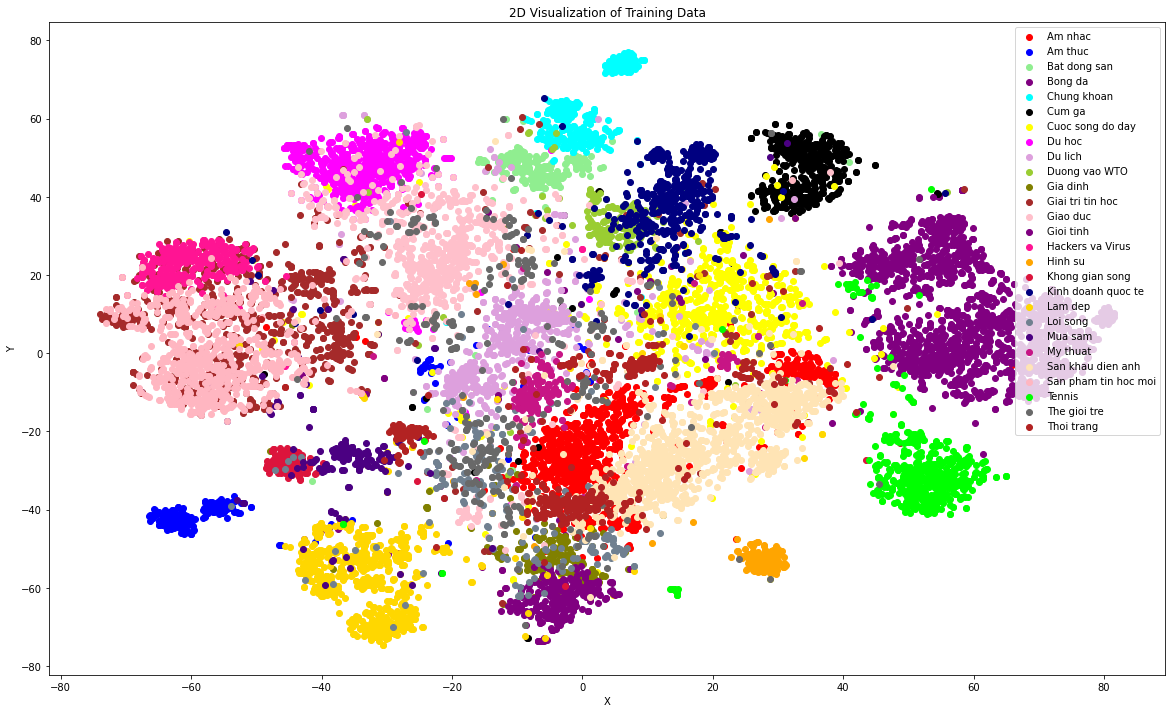

In [ ]:
# visualize
plt.figure(figsize=(20, 12))
color_map = {
    0: 'red', 1: 'blue', 2: 'lightgreen', 3: 'purple', 4: 'cyan', 5: 'black', 6: 'yellow', 7: 'magenta',
    8: 'plum', 9: 'yellowgreen', 10: 'olive', 11: 'brown', 12: 'pink', 13: 'purple', 14: 'deeppink', 
    15: 'orange', 16: 'crimson', 17: 'navy', 18: 'gold', 19: 'greenyellow', 19: 'aquamarine', 19: 'slategrey',
    20: 'indigo', 21: 'mediumvioletred', 22: 'moccasin', 23: 'lightpink', 24: 'lime', 25: 'dimgrey', 26: 'firebrick'
}

train_y = np.array(train_y)

for idx, label in enumerate(labels):
  plt.scatter(x=x_2d[train_y == label, 0], y=x_2d[train_y == label, 1], c=color_map[idx], marker='o', label=label)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('2D Visualization of Training Data')
plt.show()

**Nhận xét:** Khả năng phân cụm của PhoBERT thực sự khá tốt (dựa trên sự phân bố của các cụm màu), thậm chí có thể tốt hơn hẳn BoW + TF-IDF.

###5. Train classifier

In [ ]:
# load vector embedding đã lưu
train_features = pickle.load(open(bert_features_path, 'rb'))
test_features = pickle.load(open(bert_test_features_path, 'rb'))

**Logistic Regression Classifier**

In [ ]:
logisticReg = LogisticRegression(max_iter=100_000)

start = time.time()
logisticReg.fit(train_features, train_y)

print('Logistic Regression finish training after %d second' %(time.time() - start))

bert_logreg_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/bert_logreg.sav'
pickle.dump(logisticReg, open(bert_logreg_path, 'wb'))

Logistic Regression finish training after 250 second


In [ ]:
# Đánh giá độ chính xác của mô hình Logistic Regression
y_pred = logisticReg.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))

print('Accuracy: ', acc)

Accuracy:  0.863696588274263


In [ ]:
print(classification_report(test_y, y_pred, zero_division=1))

                      precision    recall  f1-score   support

             Am nhac       0.88      0.89      0.89       813
             Am thuc       0.96      0.91      0.94       400
        Bat dong san       0.94      0.93      0.93       282
             Bong da       0.98      0.99      0.98      1464
         Chung khoan       0.97      0.95      0.96       320
              Cum ga       0.98      0.97      0.97       381
    Cuoc song do day       0.66      0.71      0.68       405
              Du hoc       0.97      0.88      0.92       394
             Du lich       0.88      0.91      0.90       565
       Duong vao WTO       0.81      0.74      0.77       191
            Gia dinh       0.75      0.53      0.62       280
    Giai tri tin hoc       0.69      0.78      0.73       707
            Giao duc       0.84      0.87      0.86       707
           Gioi tinh       0.86      0.87      0.87       268
    Hackers va Virus       0.94      0.82      0.88       319
       

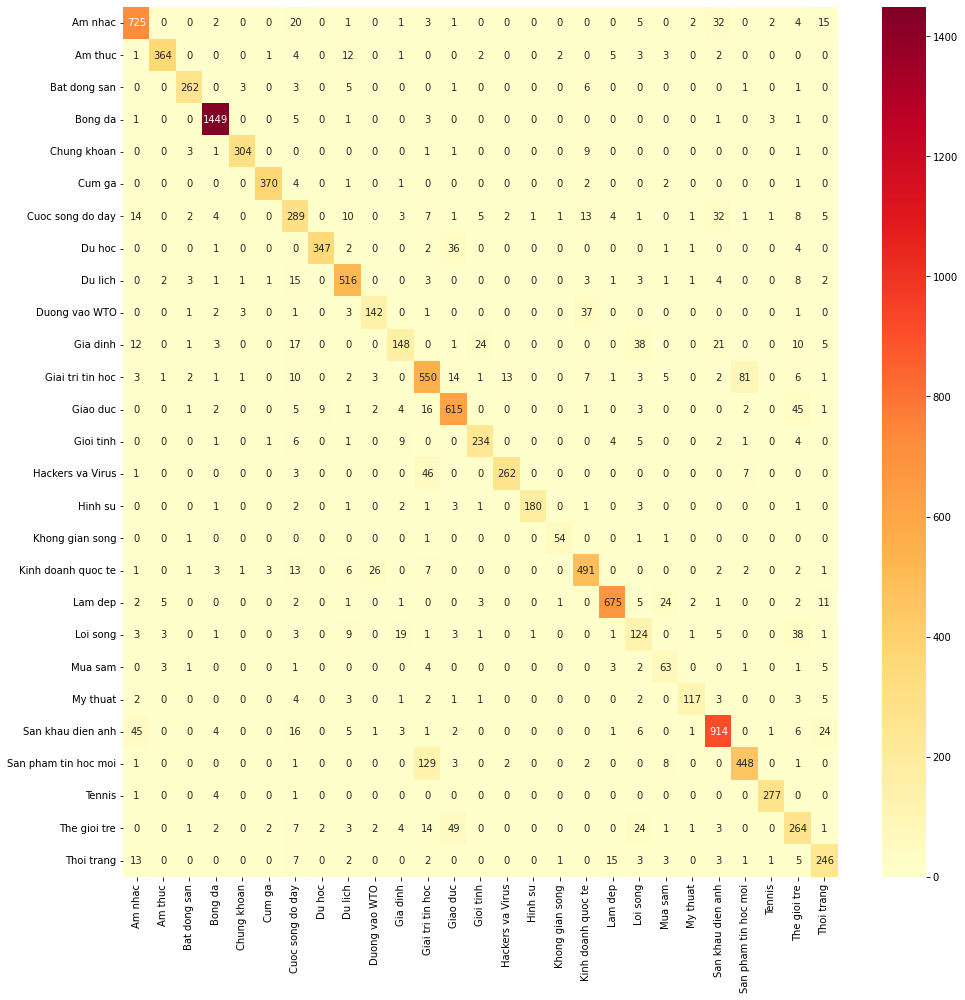

In [ ]:
# visualize bằng heat map
plt.figure(figsize=(16, 16))
conf_matrix = confusion_matrix(test_y, y_pred, labels=labels)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd' , xticklabels=labels, yticklabels=labels)

**SVM Classifier**

In [ ]:
svm = SVC()

start = time.time()
svm.fit(train_features, train_y)
print('SVM classifier finish training after %d seconds' %(time.time() - start))

bert_svm_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/bert_svm.sav'
pickle.dump(svm, open(bert_svm_path, 'wb'))

SVM classifier finish training after 55 seconds


In [ ]:
# Đánh giá độ chính xác
y_pred = svm.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))
print('Accuracy: ', acc)

Accuracy:  0.8858893673401789


In [ ]:
print(classification_report(test_y, y_pred, zero_division=1))

                      precision    recall  f1-score   support

             Am nhac       0.90      0.92      0.91       813
             Am thuc       0.98      0.92      0.95       400
        Bat dong san       0.97      0.94      0.96       282
             Bong da       0.99      0.99      0.99      1464
         Chung khoan       0.96      0.96      0.96       320
              Cum ga       0.99      0.98      0.98       381
    Cuoc song do day       0.66      0.81      0.73       405
              Du hoc       0.96      0.91      0.94       394
             Du lich       0.90      0.92      0.91       565
       Duong vao WTO       0.93      0.71      0.80       191
            Gia dinh       0.81      0.56      0.66       280
    Giai tri tin hoc       0.75      0.80      0.77       707
            Giao duc       0.87      0.90      0.88       707
           Gioi tinh       0.86      0.85      0.85       268
    Hackers va Virus       0.93      0.90      0.92       319
       

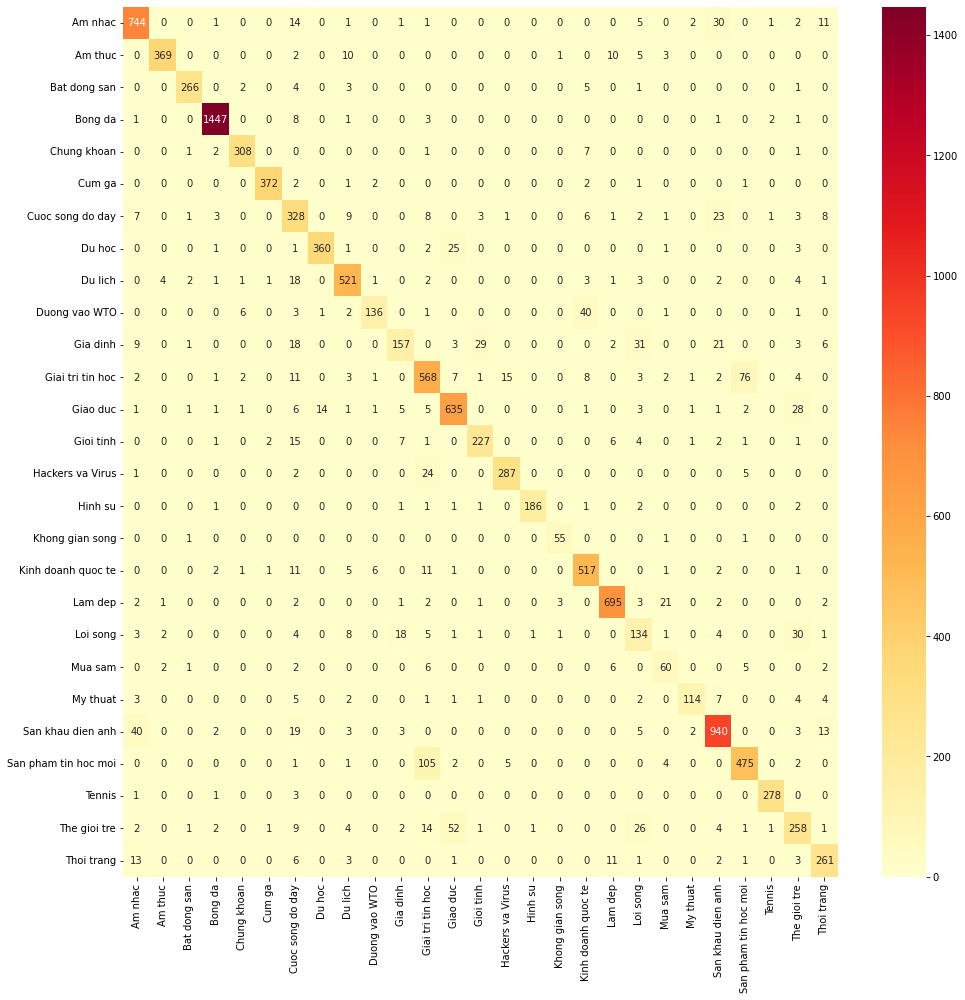

In [ ]:
# visualize bằng heat map
plt.figure(figsize=(16, 16))
conf_matrix = confusion_matrix(test_y, y_pred, labels=labels)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd' , xticklabels=labels, yticklabels=labels)

**Nhận xét:**

- Logistic Regression:
  
  + Accuracy: 86.37%
  + Training time: 250s
  + Test speed: High

- SVM:
  
  + Accuracy: 88.59%
  + Training time: 55s
  + Test speed: Medium

Ta thấy việc sử dụng BERT làm feature extractor cho model cho kết quả tốt hơn so với việc dùng Doc2Vec bởi vì việc học ngữ cảnh của BERT là tốt hơn (học theo 2 chiều thay vì 1 chiều như Doc2Vec). Chưa cần sử dụng tới fine-tune đã cho kết quả rất tốt. Điều đó chứng tỏ việc học ngữ cảnh của mô hình BERT thực sự tốt.

Trong phần tiếp theo, em sẽ fine-tune lại mô hình để đánh giá.

#Fine-tune lại mô hình PhoBERT cho tác vụ classify

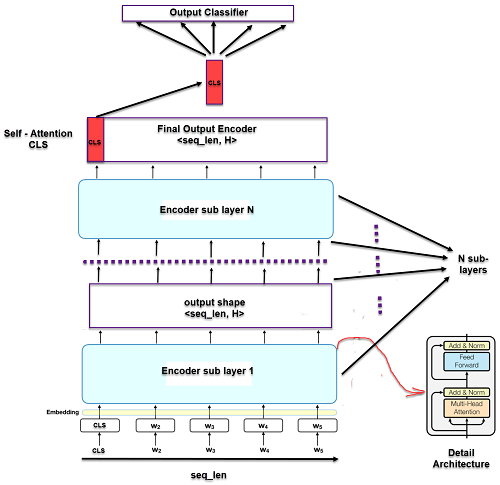

Model BERT base sử dụng 12 sub-layer với mỗi layer là một multi-head attention. Output của mỗi sub-layer có kích thước bằng input của nó, là một vector 768 chiều.

Để fine-tune được kiến trúc của BERT, ta cắt bỏ phần decoder và giữ lại encoder. Sau khi đưa sentence qua model (đã thêm các token đặc biệt) thì vector embedding của token CLS sẽ được đưa vào classify layer (fully connected layer) để phân loại.

###1. Load model PhoBERT

In [ ]:
# Load BPE encoder
parser = argparse.ArgumentParser()
parser.add_argument(
    '--bpe-codes',
    default='/content/drive/MyDrive/The Anh Tran/Final Coursework/BERT/PhoBERT_base_transformers/bpe.codes',
    required=False,
    type=str,
    help='path to fastBPE BPE'
)

args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file('/content/drive/MyDrive/The Anh Tran/Final Coursework/BERT/PhoBERT_base_transformers/dict.txt')

In [ ]:
# Ví dụ, sử dụng BPE encoder để ánh xạ 1 câu thành một list subwords
bpe.encode('Nhiệt_độ ngoài trời là 37 độ C')

'Nhiệt_độ ngoài trời là 37 độ C'

In [ ]:
# ánh xạ từng subwords sang index của nó trong vocab
vocab.encode_line('<s> ' + 'Nhiệt_độ ngoài trời là 37 độ C' + ' </s>')

tensor([   0, 3170,  227, 1027,    8, 2810,  378,  968,    2,    2],
       dtype=torch.int32)

###2. Preprocess data

In [ ]:
# encode label
le = LabelEncoder()
encoded_train_y = le.fit_transform(train_y)
print(le.classes_)

['Am nhac' 'Am thuc' 'Bat dong san' 'Bong da' 'Chung khoan' 'Cum ga'
 'Cuoc song do day' 'Du hoc' 'Du lich' 'Duong vao WTO' 'Gia dinh'
 'Giai tri tin hoc' 'Giao duc' 'Gioi tinh' 'Hackers va Virus' 'Hinh su'
 'Khong gian song' 'Kinh doanh quoc te' 'Lam dep' 'Loi song' 'Mua sam'
 'My thuat' 'San khau dien anh' 'San pham tin hoc moi' 'Tennis'
 'The gioi tre' 'Thoi trang']


In [ ]:
# chia tập train thành 2 phần train và validate với tỉ lệ 9:1
from sklearn.model_selection import train_test_split

train_sents, val_sents, train_labels, val_labels = train_test_split(train_x, encoded_train_y, test_size=0.1, random_state=1)

In [ ]:
# Thực hiện chuyển dataset ban đầu thành subword index
MAX_LEN = 256

train_ids = []
print('Processing train set ...')
for sent in tqdm(train_sents):
  subwords = '<s> ' + bpe.encode(sent) + ' </s>'
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long()
  train_ids.append(encoded_sent)

val_ids = []
print('Processing test set ...')
for sent in tqdm(val_sents):
  subwords = '<s> ' + bpe.encode(sent) + ' </s>'
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long()
  val_ids.append(encoded_sent)

Processing train set ...


  0%|          | 0/12937 [00:00<?, ?it/s]

Processing test set ...


  0%|          | 0/1438 [00:00<?, ?it/s]

In [ ]:
# thêm padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype='long', value=1, truncating='post', padding='post')
val_ids = pad_sequences(val_ids, maxlen=MAX_LEN, dtype='long', value=1, truncating='post', padding='post')

In [ ]:
# sau padding
train_ids[1]

array([    0, 25472,  7441,  9016, 22382, 56795,   115,  2518,   541,
         103,   394,   552,  1155,  3527,   686, 14385,  2482,  2253,
         409, 47670,  3482, 40516, 30362,   702,   476,  2545, 33822,
       22382, 56795,  1985,   812,   942,  1588,  1225,   379,   258,
       22382, 56795,  9863, 13330, 25472,  7441,  9016,  9863, 13330,
       25472,  7441,  9016,   143, 22382, 56795,   554,  1026, 16378,
       14708,  1397,  4846, 47670,  3482,   115,   511,  1449,  1588,
         541,   980,   349,  1136, 47670,  3482,   115,  2518,   184,
        1138, 40516, 30362,   566,   115,  3673,   541, 25472,  7441,
        9016,   508,  3951,  2489, 22382, 56795,  2604, 39628,  5062,
        9691, 48234,   633,  8526, 51128,  3529, 47670,  3482, 40516,
       30362,  6897,  8093,  9393, 34652, 17563,  2428,  2545, 12017,
        5263,  2070,   243,  2207, 55169,  1866,  9840,  1947, 57121,
         915, 25472,  7441,  9016,   374, 22382, 56795,   279,  1066,
       11120,  1078,

In [ ]:
# Tạo mask để BERT không chú ý tới padding (pad id = 1)
train_masks = []
for sent in train_ids:
  mask = [int(token_id != 1) for token_id in sent]
  train_masks.append(mask)

val_masks = []
for sent in val_ids:
  mask = [int(token_id != 1) for token_id in sent]
  val_masks.append(mask)

In [ ]:
print(train_masks[1])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 4

# convert sang tensor
train_inputs = torch.tensor(train_ids)
val_inputs = torch.tensor(val_ids)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

# tạo data loader để train
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW

NUM_CLASSES = len(labels)

# load file config
config = RobertaConfig.from_pretrained(
    '/content/drive/MyDrive/The Anh Tran/Final Coursework/BERT/PhoBERT_base_transformers/config.json',
    from_tf=False,
    num_labels=NUM_CLASSES,
    output_hidden_states=False
)

# load model
BERT_SA = RobertaForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/The Anh Tran/Final Coursework/BERT/PhoBERT_base_transformers/model.bin',
    config=config
)

In [ ]:
BERT_SA.cuda()
print('Done')

Done


In [ ]:
# Hàm đánh giá độ chính xác
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  F1_score = f1_score(pred_flat, labels_flat, average='macro')

  return accuracy_score(pred_flat, labels_flat), F1_score

In [ ]:
# định nghĩa tham số
device = 'cuda'
epochs = 10
save_dir = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/Bert Fine-tune'
best_acc = 0

# lưu lại lịch sử
losses = []
train_accs = []
val_accs = []

# define optimizer
param_optimizer = list(BERT_SA.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)

# Train theo từng epoch
for epoch_i in range(0, epochs):
  print('================= Epoch {} / {} ====================='.format(epoch_i + 1, epochs))
  print('Training ... ')

  # Tham số train
  total_loss = 0
  BERT_SA.train()
  train_accuracy = 0
  nb_train_steps = 0
  train_f1 = 0

  # Train từng batch
  for step, batch in enumerate(tqdm(train_dataloader)):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    BERT_SA.zero_grad()
    outputs = BERT_SA(
        b_input_ids,
        token_type_ids=None,
        attention_mask=b_input_mask,
        labels=b_labels
    )
    loss = outputs[0]
    total_loss += loss.item()

    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
    train_accuracy += tmp_train_accuracy
    train_f1 += tmp_train_f1
    nb_train_steps += 1

    loss.backward()
    torch.nn.utils.clip_grad_norm_(BERT_SA.parameters(), 1.0)
    optimizer.step()

  # tính average loss và accuracy cho epoch đó
  avg_train_loss = total_loss / len(train_dataloader)
  losses.append(avg_train_loss)
  train_accs.append(train_accuracy/nb_train_steps)

  print('Accuracy: {0:.4f}'.format(train_accuracy/nb_train_steps))
  print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
  print(" Average training loss: {0:.4f}".format(avg_train_loss))

  print("Running Validation...")

  BERT_SA.eval()

  # tham số validate
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  eval_f1 = 0

  # đánh giá
  for batch in tqdm(val_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = BERT_SA(
          b_input_ids,
          token_type_ids=None,
          attention_mask=b_input_mask
      )
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      eval_f1 += tmp_eval_f1
      nb_eval_steps += 1

  avg_val_acc = eval_accuracy/nb_eval_steps
  val_accs.append(avg_val_acc)
  print(" Accuracy: {0:.4f}".format(avg_val_acc))
  print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))

  # save checkpoint
  if avg_val_acc > best_acc:
    # save checkpoint
    print('Saved model to %s' %save_dir)
    BERT_SA.save_pretrained(save_dir)
    best_acc = avg_val_acc

  # early stopping
  if epoch_i >= 4: # Khởi động 3 epochs
    if avg_val_acc < val_accs[-2]:
      # bị overfit
      print('Early stopping!')
      break
print("Training complete!")

================= Epoch 1 / 10 =====================
Training ... 


  0%|          | 0/3235 [00:00<?, ?it/s]

Accuracy: 0.9571
 F1 score: 0.9334
 Average training loss: 0.2583
Running Validation...


  0%|          | 0/360 [00:00<?, ?it/s]

 Accuracy: 0.9181
 F1 score: 0.8732
Saved model to /content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/Bert Fine-tune


/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


================= Epoch 2 / 10 =====================
Training ... 


  0%|          | 0/3235 [00:00<?, ?it/s]

Accuracy: 0.9770
 F1 score: 0.9640
 Average training loss: 0.1361
Running Validation...


  0%|          | 0/360 [00:00<?, ?it/s]

 Accuracy: 0.9236
 F1 score: 0.8804
Saved model to /content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/Bert Fine-tune
================= Epoch 3 / 10 =====================
Training ... 


  0%|          | 0/3235 [00:00<?, ?it/s]

Accuracy: 0.9819
 F1 score: 0.9716
 Average training loss: 0.1082
Running Validation...


  0%|          | 0/360 [00:00<?, ?it/s]

 Accuracy: 0.9201
 F1 score: 0.8755
================= Epoch 4 / 10 =====================
Training ... 


  0%|          | 0/3235 [00:00<?, ?it/s]

Accuracy: 0.9855
 F1 score: 0.9777
 Average training loss: 0.0889
Running Validation...


  0%|          | 0/360 [00:00<?, ?it/s]

 Accuracy: 0.9215
 F1 score: 0.8771
================= Epoch 5 / 10 =====================
Training ... 


  0%|          | 0/3235 [00:00<?, ?it/s]

Accuracy: 0.9886
 F1 score: 0.9820
 Average training loss: 0.0659
Running Validation...


  0%|          | 0/360 [00:00<?, ?it/s]

 Accuracy: 0.9118
 F1 score: 0.8648


NameError: ignored

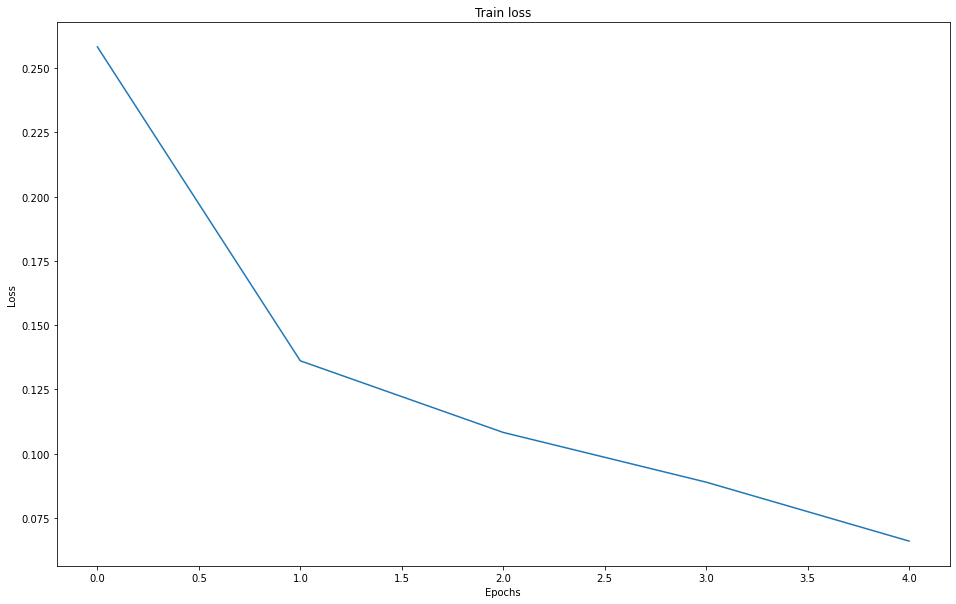

In [ ]:
# đồ thị loss
plt.figure(figsize=(16, 10))
plt.plot(range(len(losses)), losses)
plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

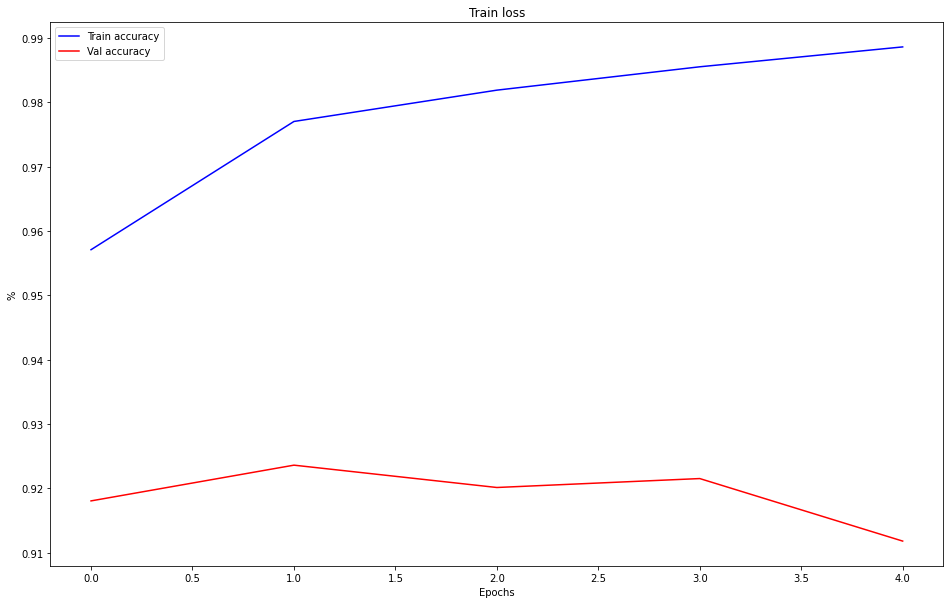

In [ ]:
# lịch sử accuracy
plt.figure(figsize=(16, 10))
plt.plot(range(len(train_accs)), train_accs, 'b', label='Train accuracy')
plt.plot(range(len(val_accs)), val_accs, 'r', label='Val accuracy')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend()
plt.show()

In [ ]:
print('Best accuracy: ', best_acc)

Best accuracy:  0.9236111111111112


**Nhận xét:** Kết quả đạt được bằng cách fine-tune model PhoBERT là **92.36%**. Đây là kết quả cao nhất đạt được cho đến thời điểm hiện tại. Có thể thấy, cách này tốt hơn so với việc sử dụng BoW + TF-IDF, tuy nhiên, việc train và test tốn nhiều thời gian hơn, và phức tạp hơn rất nhiều. Vì vậy, nếu muốn đơn giản, gọn nhẹ, ít tốn thời gian và không yêu cầu quá khắt khe về mặt độ chính xác thì dùng BoW + TF-IDF kết hợp với Logistic Regression đã là rất tốt.

Tóm lại, Fine-tune BERT:
  
  - Accuracy: 92.36%
  - Training time: few hours
  - Test speed: Low